In [3]:
import numpy as np
import cv2
%matplotlib inline
%matplotlib widget
from matplotlib import pyplot as plt
import math

If we have two cameras parallel to each other, it is relatively easy to estimate the depth of an image in 3D. Given the correspondent points and calibration matrices of the cameras, we use linear algebra to perform singular value decomposition on a matrix A. The matrix A is composed of correspondent points and calibration matrices and its eigenvector with the lowest eigenvalue gives us the coordinates of a point in 3D. Below you can observe a 3D interactive graph that shows us where the points from our 2D images lay in a 3D space.

In [1]:
def triangulate(x1,x2,P1,P2):

    #1. dodamo homogene koordinate 2D tockam
    x1 = np.append(x1,np.ones((x1.shape[0],1)),axis=1)
    x2 = np.append(x2,np.ones((x2.shape[0],1)),axis=1)
    X = np.ones((x1.shape[0],4))

    for i in np.arange(x1.shape[0]):
        p1 = x1[i,:]
        p2 = x2[i,:]
        #2. sestavimo matriko A iz prvih dveh vrstic [x1x]P1 in prvih dveh vrstic [x2x]P2
        A1 = np.array([[0, -p1[2], p1[1]], [p1[2], 0, -p1[0]], [-p1[1], p1[0], 0], [1,1,1]])
        A2 = np.array([[0, -p2[2], p2[1]], [p2[2], 0, -p2[0]], [-p2[1], p2[0], 0], [1,1,1]])
        A1 = A1 @ P1
        A2 = A2 @ P2
        A = np.stack([A1[0,:], A1[1,:],A2[0,:], A2[1,:]])

        #3. vzamemo samo zadnji eigen vector in ga delimo z zadnjim elementom da ga normaliziramo
        U,D,V = np.linalg.svd(A)
        V = np.transpose(V)
        X[i,:] = V[:,-1] / V[-1,-1]

    #4. varcamo brez homogene koordinate
    return X[:,0:3]


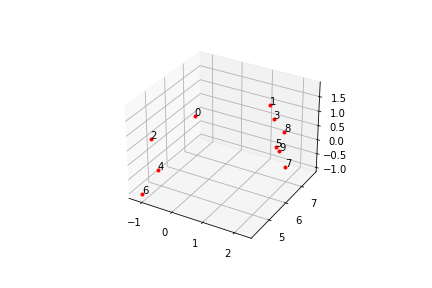

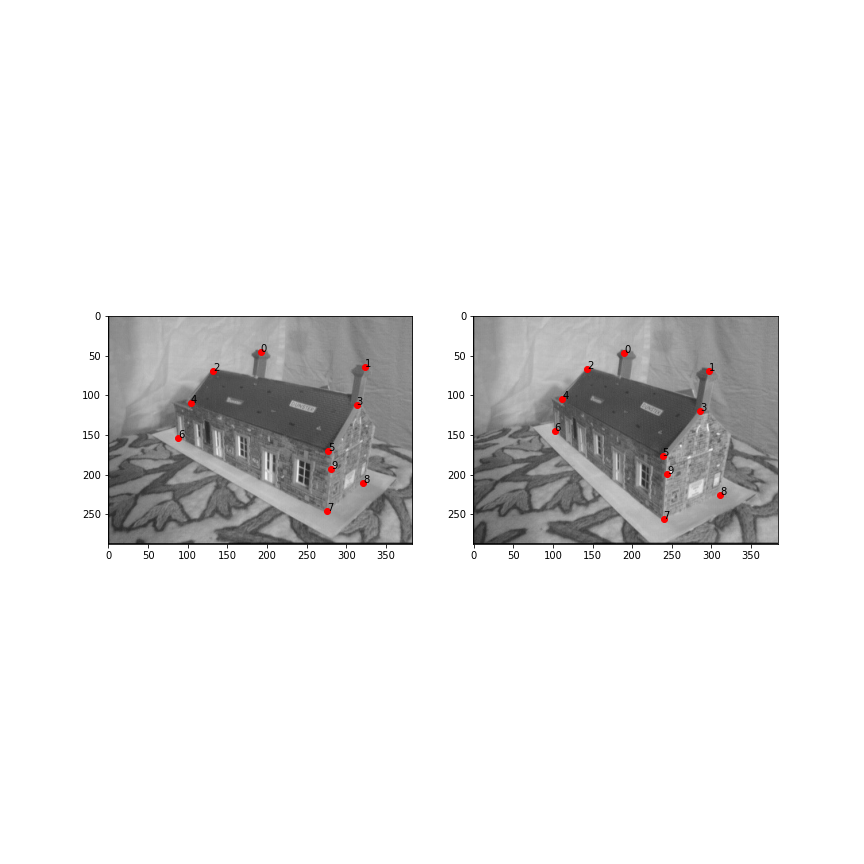

In [7]:

# reading the images
I1 = cv2.imread("data/epipolar/house1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY)
I2 = cv2.imread("data/epipolar/house2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)

# calibration matrices and correspondences
m = np.loadtxt('data/epipolar/house_points.txt', usecols=range(4))
P1 = np.loadtxt('data/epipolar/house1_camera.txt')
P2 = np.loadtxt('data/epipolar/house2_camera.txt')
x1 = m[:,0:2]
x2 = m[:,2:4]

# calculate 3D coordinates
res = triangulate(x1,x2,P1,P2)

# images with points
_, ax = plt.subplots(1, 2, figsize=(12, 12),squeeze=False)
ax[0][0].plot(x1[:,0],x1[:,1],'o',color='red')
ax[0][1].plot(x2[:,0],x2[:,1],'o',color='red')

for i in np.arange(x1.shape[0]):
    ax[0][0].text(x1[i,0], x1[i,1], str(i))
    ax[0][1].text(x2[i,0], x2[i,1], str(i))

ax[0][0].imshow(I1, cmap="gray")
ax[0][1].imshow(I2, cmap="gray")


# 3D graph with changed coordinate system
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T = np.array([[-1,0,0],[0,0,1],[0,-1,0]])
res = np.dot(res,T)

for i, pt in enumerate(res):
    plt.plot([pt[0]],[pt[1]],[pt[2]],'r.')
    ax.text(pt[0],pt[1],pt[2], str(i))

plt.show()